In [1]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

## Load data

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

In [3]:
books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

In [47]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

## Clean data

### Plot the counts per user and per book

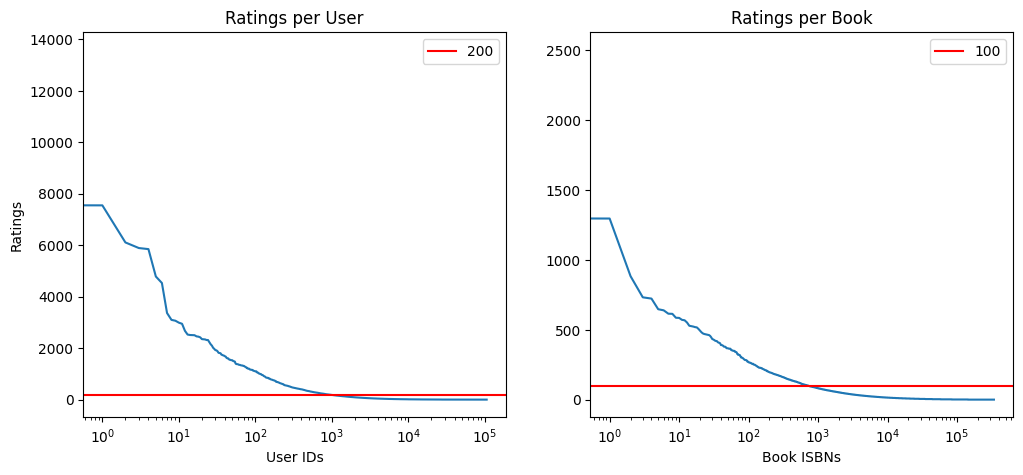

In [48]:
# create a dataframe of ratings per user, sorted by descending count
user_counts = (
    df_ratings
        .groupby('user', as_index=False)
        .size()
        .sort_values('size', ascending=False)
        .reset_index(drop=True)
        .drop(columns='user')
)

# create a dataframe of ratings per user, sorted by descending count
book_counts = (
    df_ratings
        .groupby('isbn', as_index=False)
        .size()
        .sort_values('size', ascending=False)
        .reset_index(drop=True)
        .drop(columns='isbn')
)


# plot the counts with markers at 200 per user and 100 per book
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.plot(user_counts.index, user_counts['size'])
ax2.plot(book_counts.index, book_counts['size'])
ax1.set_xscale('log')
ax2.set_xscale('log')
ax1.set_title('Ratings per User')
ax2.set_title('Ratings per Book')
ax1.axhline(y=200, color='r', label='200')
ax2.axhline(y=100, color='r', label='100')
ax1.set_ylabel('Ratings')
ax1.set_xlabel('User IDs')
ax2.set_xlabel('Book ISBNs')
ax1.legend()
ax2.legend()

### Remove users with <200 ratings and books with <100 ratings

In [49]:
print(f'Shape before: {df_ratings.shape}')
user_mask = df_ratings.groupby('user')['rating'].transform('size') >= 200
book_mask = df_ratings.groupby('isbn')['rating'].transform('size') >= 100
df_ratings = df_ratings[user_mask & book_mask]
print(f'Shape after: {df_ratings.shape}')

Shape before: (1149780, 3)
Shape after: (49781, 3)


## Prepare the data (create a sparse matrix)

In [54]:
# pivot the data into a matrix with rows for books and columns for users
df_pivot = df_ratings.pivot(index='isbn', columns='user', values='rating').fillna(0)

# Create a sparse matrix
ratings_matrix = csr_matrix(df_pivot.values)

# create the model using cosine for similarity
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=5)

# fit the model
model.fit(ratings_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

## Create mappers
Create mappers to map between book names and rows in the matrix

In [55]:
# create a dataframe with the same rows as the matrix and join with df_books to add the title
df_map = (
    df_pivot.index
        .to_frame()
        .reset_index(drop=True)
        .merge(df_books, how='left', on='isbn')
)

df_map.head()

,isbn,title,author
0,002542730X,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,0060008032,Angels,Marian Keyes
2,0060096195,The Boy Next Door,Meggin Cabot
3,006016848X,"Men Are from Mars, Women Are from Venus: A Pra...",John Gray
4,0060173289,Divine Secrets of the Ya-Ya Sisterhood : A Novel,Rebecca Wells


In [56]:
# fill in any blank titles with the isbn
print(f'Filling in {df_map["title"].isna().sum()} blank titles')
has_blank_title = df_map['title'].isna()
df_map.loc[has_blank_title, 'title'] = df_map.loc[has_blank_title, 'isbn']

Filling in 4 blank titles


In [57]:
# Create a dict mapping index to book name 
index_to_book_map = df_map['title'].to_dict()

# Create a dict mapping book names to indexes
book_to_index_map = {v: k for k, v in index_to_book_map.items()}

In [74]:
# print an example of each
print(f'the book at index 33 is {index_to_book_map[133]}')

print(f'the index for "Fahrenheit 451" is {book_to_index_map["Fahrenheit 451"]}')

the book at index 33 is Fahrenheit 451
the index for "Fahrenheit 451" is 133


## Recommender function

In [76]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):
    # get the corresponding row from the matrix
    index = book_to_index_map[book]
    matrix_row = ratings_matrix[index]
    
    # get recommendations
    distances, indices = model.kneighbors(matrix_row, n_neighbors=6)
    
    recommended_books = []
    
    # loop through results and assemble recommendations in the format ["book title", distance]
    for (d, i) in zip(distances[0], indices[0]):
        recommended_books.append([index_to_book_map[i], d])
        
    # remove the first (closest) recommendation, which will be the book itself
    recommended_books.pop(0)
    
    # reverse the list
    recommended_books.reverse()
    
    return [book, recommended_books]

## Test

In [77]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
